In [1]:
import os
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import random
from pathlib import Path
import torch.backends.cudnn as cudnn
import torch
import sys

from utils import PSNR, loss_psnr_graphic, model_to_baseline_compare

PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.append(str(PROJECT_ROOT))
from src.models import RCAN, CharbonnierLoss
from src.dataset import SatelliteSRDataset

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device )

cuda


In [2]:
BATCH_SIZE = 16
EPOCHS = 200

DATA_DIR = Path.home() / '.data'
TRAIN_DIR = Path.home() / '.data' / 'UCMerced_LandUse_Split' / 'train'
VAL_DIR = Path.home() / '.data' / 'UCMerced_LandUse_Split' / 'val'
MODEL_DIR = Path.home() / '.data' / 'models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)


In [4]:
train_dataset = SatelliteSRDataset(TRAIN_DIR, mode='y', hr_patch_size=144, augment=True)
val_dataset = SatelliteSRDataset(VAL_DIR, mode='y', hr_patch_size=144, augment=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

model = RCAN(num_channels=1).to(device)

criterion = CharbonnierLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)


In [ ]:
train_loss = []
psnr_metric = []
best_psnr = 0
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch}"):
        lr_imgs, hr_imgs = lr_imgs.to(device, non_blocking=True), hr_imgs.to(device, non_blocking=True)
        optimizer.zero_grad()
        sr_imgs = model(lr_imgs)
        batch_loss = criterion(sr_imgs, hr_imgs)
        batch_loss.backward()
        optimizer.step()
        epoch_loss += batch_loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_loss.append(avg_loss)

    model.eval()
    val_loss = 0
    val_psnr = 0
    with torch.no_grad():
        for lr_imgs, hr_imgs in val_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)

            loss = criterion(sr_imgs, hr_imgs)
            val_loss += loss.item()
            val_psnr += PSNR(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_psnr = val_psnr / len(val_loader)

    psnr_metric.append(avg_val_psnr)
    print(f"Epoch {epoch}: Train Loss: {avg_loss:.5f} | Val Loss: {avg_val_loss:.5f} | Val PSNR: {avg_val_psnr:.2f} dB")

    scheduler.step(avg_val_loss)

    if avg_val_psnr > best_psnr:
        best_psnr = avg_val_psnr
        torch.save(model.state_dict(), MODEL_DIR / 'y_rcan_best_model.pth')
        print(f"  [!] New Best PSNR: {best_psnr:.2f} dB saved.")

    if epoch % 20 == 0:
         torch.save(model.state_dict(), MODEL_DIR / f'y_rcan_checkpoint_{epoch}.pth')

print("training complete.")


In [ ]:
loss_psnr_graphic(train_loss, psnr_metric)

File: /home/aaa/.data/UCMerced_LandUse_Split/val/runway/runway24.tif


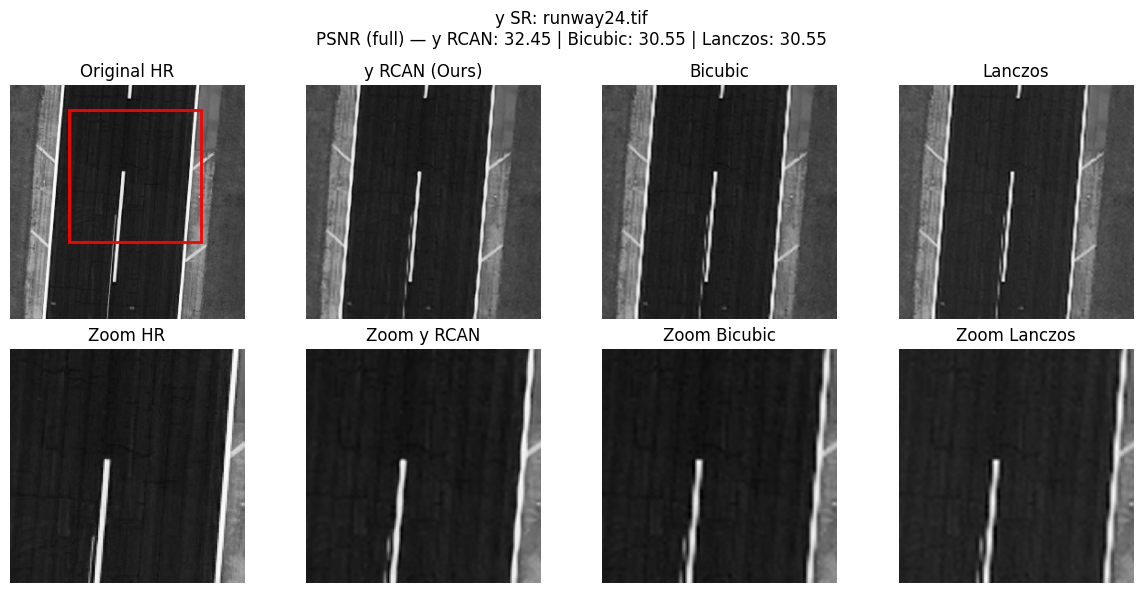

Zoom Area: Top=27, Left=64, Size=144


In [11]:
model_to_baseline_compare(
    model_class=RCAN,
    model_path=Path.home() / '.data' / 'y_rcan_best_model.pth',
    dataset=val_dataset,
    mode='y',
    model_args={'num_channels': 1}
)